In [1]:
import pandas as pd
from tqdm import tqdm
tqdm.pandas()
pd.options.display.max_columns=None

import numpy as np

import tensorflow as tf

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

import matplotlib.pyplot as plt
import pickle


In [91]:
import wandb
from wandb.keras import WandbCallback

wandb.init(project="foot_LSTM_players_noFT", entity="padda")

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: padda (use `wandb login --relogin` to force relogin)


In [2]:
def cm_metrics(true_label,pred_label, labels_):
  cm = confusion_matrix(true_label,pred_label,labels = labels_)
  cmDisp = ConfusionMatrixDisplay(cm,display_labels=labels_)
  recall = { i:cm[i][i]/cm[i].sum()  for i in range(len(cm))}
  precision = { i:cm[i][i]/cm[:,i].sum()  for i in range(len(cm))}
  F1_score = { i: 2 / (1/recall[i] + 1/precision[i]) for i in range(len(cm))}
  accuracy = (cm[0][0]+cm[1][1]+cm[2][2])/cm.sum()
  print('accuracy: ', accuracy)
  print('Recall: \n',recall,'\nPrecision: \n', precision,'\nF1-score: \n',F1_score)
  cmDisp.plot()
  plt.show()
  return None

In [5]:
home_history = pd.read_csv('../data/train_LSTM/home_history.csv', index_col = 0,\
    dtype={'home_id' : np.int32, 'game_id' : np.int32, 'H_goals' : np.int8, 'H_goals_conceded' : np.int8,\
         'H_HorA' : np.int8, 'H_yellow_cards' : np.int8, 'H_red_cards' : np.int8}\
    )

away_history = pd.read_csv('../data/train_LSTM/away_history.csv', index_col = 0,\
    dtype={'away_id' : np.int32, 'game_id' : np.int32, 'A_goals' : np.int8, 'A_goals_conceded' : np.int8,\
         'A_HorA' : np.int8, 'A_yellow_cards' : np.int8, 'A_red_cards' : np.int8}\
    )

In [6]:
train_df = pd.read_csv('../data/train_LSTM/train_LSTM.csv', index_col = 0)

In [11]:
train_df.drop(columns=['home_history','away_history'], inplace = True)

In [16]:

# on rajoute des 0 et des 1 au début de chaque ligne pour indiquer si il y a un match ou pas
# on inverse le game_history avec np.flip(game_history,axis=1) pour classer les matches du plus ancien au plus récent
# Cela dit l'expérience montre que cette inversion n'a pas énormément d'impact sur les performances du modèle... 

def make_home_train(game_id):
    game_history = home_history.loc[home_history.game_id == game_id,:].drop(columns=['home_id','game_id'])
    if (n_lines := game_history.shape[0]) == 0:
        return np.zeros((10,6)).astype(np.int8)
    else:
        return np.vstack(( np.zeros((10-n_lines,6)) , np.hstack(( np.ones((n_lines,1)) , np.flip(game_history.to_numpy(),axis=1))) )).astype(np.int8)

def make_away_train(game_id):
    game_history = away_history.loc[away_history.game_id == game_id,:].drop(columns=['away_id','game_id'])
    if (n_lines := game_history.shape[0]) == 0:
        return np.zeros((10,6)).astype(np.int8)
    else:
        return np.vstack(( np.zeros((10-n_lines,6)) , np.hstack(( np.ones((n_lines,1)) , np.flip(game_history.to_numpy(),axis=1))) )).astype(np.int8)


In [17]:
game_ids = train_df.game_id.astype(np.int32)

train_home = game_ids.progress_apply(make_home_train)
train_home = np.stack(train_home.values)

train_away = game_ids.progress_apply(make_away_train)
train_away = np.stack(train_away.values)

100%|██████████| 29545/29545 [00:29<00:00, 1018.16it/s]


In [22]:
train_df.Home_result=train_df.Home_result.apply(lambda x: np.int8(0) if x>0 else (np.int8(2) if x<0 else np.int8(1)))
y = train_df.Home_result.values

## Normalisation
. On divise (H/A)\_(attack/defense/midfield) par 5  
. idem pour (H/A)\_(GK/ATK/DEF/MF)\_(skill_moves/international_reputation/weak_foot) comme ce sont des notes sur 5  
. tout le reste divisé par 100


In [25]:
X = train_df.loc[:,train_df.columns[1:-1]].astype(np.float16).copy()
X.head()

,H_GK,H_GK_overall,H_GK_potential,H_GK_skill_moves,H_GK_international_reputation,H_GK_weak_foot,H_GK_attacking_crossing,H_GK_attacking_heading_accuracy,H_GK_skill_curve,H_GK_skill_fk_accuracy,H_GK_movement_agility,H_GK_movement_reactions,H_GK_movement_balance,H_GK_power_shot_power,H_GK_power_jumping,H_GK_power_stamina,H_GK_mentality_aggression,H_GK_mentality_positioning,H_GK_mentality_penalties,H_GK_goalkeeping_diving,H_GK_goalkeeping_speed,H_attack,H_ATK_overall,H_ATK_potential,H_ATK_skill_moves,H_ATK_international_reputation,H_ATK_weak_foot,H_ATK_pace,H_ATK_shooting,H_ATK_passing,H_ATK_dribbling,H_ATK_defending,H_ATK_physic,H_ATK_attacking_crossing,H_ATK_attacking_heading_accuracy,H_ATK_skill_curve,H_ATK_skill_fk_accuracy,H_ATK_movement_agility,H_ATK_movement_reactions,H_ATK_movement_balance,H_ATK_power_shot_power,H_ATK_power_jumping,H_ATK_power_stamina,H_ATK_mentality_aggression,H_ATK_mentality_positioning,H_ATK_mentality_penalties,H_ATK_mentality_composure,H_defense,H_DEF_overall,H_DEF_potential,H_DEF_skill_moves,H_DEF_international_reputation,H_DEF_weak_foot,H_DEF_pace,H_DEF_shooting,H_DEF_passing,H_DEF_dribbling,H_DEF_defending,H_DEF_physic,H_DEF_attacking_crossing,H_DEF_attacking_heading_accuracy,H_DEF_skill_curve,H_DEF_skill_fk_accuracy,H_DEF_movement_agility,H_DEF_movement_reactions,H_DEF_movement_balance,H_DEF_power_shot_power,H_DEF_power_jumping,H_DEF_power_stamina,H_DEF_mentality_aggression,H_DEF_mentality_positioning,H_DEF_mentality_penalties,H_DEF_mentality_composure,H_midfield,H_MF_overall,H_MF_potential,H_MF_skill_moves,H_MF_international_reputation,H_MF_weak_foot,H_MF_pace,H_MF_shooting,H_MF_passing,H_MF_dribbling,H_MF_defending,H_MF_physic,H_MF_attacking_crossing,H_MF_attacking_heading_accuracy,H_MF_skill_curve,H_MF_skill_fk_accuracy,H_MF_movement_agility,H_MF_movement_reactions,H_MF_movement_balance,H_MF_power_shot_power,H_MF_power_jumping,H_MF_power_stamina,H_MF_mentality_aggression,H_MF_mentality_positioning,H_MF_mentality_penalties,H_MF_mentality_composure,A_GK,A_GK_overall,A_GK_potential,A_GK_skill_moves,A_GK_international_reputation,A_GK_weak_foot,A_GK_attacking_crossing,A_GK_attacking_heading_accuracy,A_GK_skill_curve,A_GK_skill_fk_accuracy,A_GK_movement_agility,A_GK_movement_reactions,A_GK_movement_balance,A_GK_power_shot_power,A_GK_power_jumping,A_GK_power_stamina,A_GK_mentality_aggression,A_GK_mentality_positioning,A_GK_mentality_penalties,A_GK_goalkeeping_diving,A_GK_goalkeeping_speed,A_attack,A_ATK_overall,A_ATK_potential,A_ATK_skill_moves,A_ATK_international_reputation,A_ATK_weak_foot,A_ATK_pace,A_ATK_shooting,A_ATK_passing,A_ATK_dribbling,A_ATK_defending,A_ATK_physic,A_ATK_attacking_crossing,A_ATK_attacking_heading_accuracy,A_ATK_skill_curve,A_ATK_skill_fk_accuracy,A_ATK_movement_agility,A_ATK_movement_reactions,A_ATK_movement_balance,A_ATK_power_shot_power,A_ATK_power_jumping,A_ATK_power_stamina,A_ATK_mentality_aggression,A_ATK_mentality_positioning,A_ATK_mentality_penalties,A_ATK_mentality_composure,A_defense,A_DEF_overall,A_DEF_potential,A_DEF_skill_moves,A_DEF_international_reputation,A_DEF_weak_foot,A_DEF_pace,A_DEF_shooting,A_DEF_passing,A_DEF_dribbling,A_DEF_defending,A_DEF_physic,A_DEF_attacking_crossing,A_DEF_attacking_heading_accuracy,A_DEF_skill_curve,A_DEF_skill_fk_accuracy,A_DEF_movement_agility,A_DEF_movement_reactions,A_DEF_movement_balance,A_DEF_power_shot_power,A_DEF_power_jumping,A_DEF_power_stamina,A_DEF_mentality_aggression,A_DEF_mentality_positioning,A_DEF_mentality_penalties,A_DEF_mentality_composure,A_midfield,A_MF_overall,A_MF_potential,A_MF_skill_moves,A_MF_international_reputation,A_MF_weak_foot,A_MF_pace,A_MF_shooting,A_MF_passing,A_MF_dribbling,A_MF_defending,A_MF_physic,A_MF_attacking_crossing,A_MF_attacking_heading_accuracy,A_MF_skill_curve,A_MF_skill_fk_accuracy,A_MF_movement_agility,A_MF_movement_reactions,A_MF_movement_balance,A_MF_power_shot_power,A_MF_power_jumping,A_MF_power_stamina,A_MF_mentality_aggression,A_MF_mentality_positioning,A_MF_mentality_penalties,

In [27]:
col_select = [x+y for x in ['H_','A_'] for y in ['attack', 'defense', 'midfield']]
X.loc[:,col_select]=X.loc[:,col_select]/5

In [31]:
col_select1 = [x+y+z for x in ['H_','A_'] for y in ['GK_','ATK_','DEF_','MF_'] for z in ['skill_moves','international_reputation','weak_foot']]
X.loc[:,col_select1]=X.loc[:,col_select1]/5

In [34]:
col_select2 = col_select+col_select1+['H_GK','A_GK']
col_mask = [x  for x in X.columns if (x not in col_select2)]
X.loc[:,col_mask]=X.loc[:,col_mask]/100

In [38]:
X = X.to_numpy()

In [65]:
class DataGenerator(tf.keras.utils.Sequence):
  def __init__(self, xh_data, xa_data, xplayer_data, y_data, batch_size):
    self.xh, self.xa, self.xplayer, self.y = xh_data, xa_data, xplayer_data,y_data
    self.batch_size = batch_size
    self.num_batches = np.ceil(len(xh_data) / batch_size)
    self.batch_idx = np.array_split(range(len(xh_data)), self.num_batches)

  def __len__(self):
    return len(self.batch_idx)

  def __getitem__(self, idx):
    batch_xh = self.xh[self.batch_idx[idx]]
    batch_xa = self.xa[self.batch_idx[idx]]
    batch_xplayer = self.xplayer[self.batch_idx[idx]]
    batch_y = self.y[self.batch_idx[idx]]
    return [batch_xh,batch_xa,batch_xplayer], batch_y


In [66]:
XH_train, XH_test, XA_train, XA_test, Xplayers_train, Xplayers_test, y_train, y_test \
    = train_test_split(train_home, train_away, X, y, test_size = 0.25, random_state=0, stratify=y)

In [67]:
train_data = DataGenerator(XH_train,XA_train,Xplayers_train,y_train,64)
test_data = DataGenerator(XH_test,XA_test,Xplayers_test,y_test,20)

# Modèle 
#### avec pré-entrainement sans fine-tuning

In [197]:
LSTM_model = tf.keras.models.load_model('../data/models/LSTM_only')

In [220]:
LSTM_model.trainable=False

In [270]:
from tensorflow.keras.regularizers import L1L2

In [277]:
# on retire la dernière couche du modèle
penultimate_layer = LSTM_model.layers[-7]
base_LSTM_model = tf.keras.Model(LSTM_model.inputs,penultimate_layer.output)
base_LSTM_model.trainable=True
for layer in base_LSTM_model.layers:
    print(layer.name,end='  ')

setattr(base_LSTM_model.layers[2], 'kernel_regularizer', L1L2(l1=0.01, l2=0.01))


home_train_input  away_train_input  home_LSTM_2  away_LSTM_2  concatenate_23  

AttributeError: Can't set the attribute "kernel_regularizer", likely because it conflicts with an existing read-only @property of the object. Please choose a different name.

wandb: Network error (ReadTimeout), entering retry loop.
wandb: Network error (ConnectionError), entering retry loop.
wandb: Network error (ReadTimeout), entering retry loop.
wandb: Network error (ConnectionError), entering retry loop.
wandb: Network error (ConnectionError), entering retry loop.
wandb: Network error (ConnectionError), entering retry loop.
wandb: Network error (ConnectionError), entering retry loop.
wandb: Network error (ConnectionError), entering retry loop.
wandb: Network error (ConnectTimeout), entering retry loop.
wandb: Network error (ConnectionError), entering retry loop.
wandb: Network error (ConnectionError), entering retry loop.
wandb: Network error (ReadTimeout), entering retry loop.
wandb: Network error (ConnectionError), entering retry loop.
wandb: Network error (ReadTimeout), entering retry loop.
wandb: Network error (ConnectionError), entering retry loop.
wandb: Network error (ConnectionError), entering retry loop.
wandb: Network error (ConnectionError), e

In [249]:
base_LSTM_model = LSTM_model
base_LSTM_model.trainable=True
for layer in base_LSTM_model.layers[:-5]:
    print(layer.name,end='  ')
    #layer.trainable = False


home_train_input  away_train_input  home_LSTM_2  away_LSTM_2  concatenate_23  dropout_59  

In [189]:
home_input = tf.keras.Input(shape = (10,6), name = 'home_train_input')  
away_input = tf.keras.Input(shape = (10,6), name = 'away_train_input')  
LSTM_output = base_LSTM_model([home_input,away_input])  
LSTM_output = tf.keras.layers.Dropout(0.34)(LSTM_output)  
#LSTM_output = tf.keras.layers.BatchNormalization()(LSTM_output)


player_input = tf.keras.Input(shape = (198), name = 'player_train_input')  
concat_layer = tf.keras.layers.Concatenate(name='concat_layer')([LSTM_output,player_input])  
Dense1 = tf.keras.layers.Dense(256,'relu',name = 'Dense1')(concat_layer)  
Dense1 = tf.keras.layers.Dropout(0.234375)(Dense1)  
Dense2 = tf.keras.layers.Dense(128,'relu',name='Dense2')(Dense1)  
Dense2 = tf.keras.layers.Dropout(0.125)(Dense2)  
Dense_output = tf.keras.layers.Dense(3, 'softmax', name='output')(Dense2)   



In [259]:
home_input = tf.keras.Input(shape = (10,6), name = 'home_train_input')  
away_input = tf.keras.Input(shape = (10,6), name = 'away_train_input')  
LSTM_output = base_LSTM_model([home_input,away_input])  
#LSTM_output = tf.keras.layers.Dropout(0.34)(LSTM_output)  
#LSTM_output = tf.keras.layers.BatchNormalization()(LSTM_output)


player_input = tf.keras.Input(shape = (198), name = 'player_train_input')    
Dense1 = tf.keras.layers.Dense(256,'relu',name = 'Dense1')(player_input)  
Dense1 = tf.keras.layers.Dropout(0.2)(Dense1)  

concat_layer = tf.keras.layers.Concatenate(name='concat_layer')([LSTM_output,Dense1])  
concat_layer = tf.keras.layers.Dropout(0.234375)(concat_layer)  
Dense2 = tf.keras.layers.Dense(128,'relu',name='Dense2')(concat_layer)  
Dense2 = tf.keras.layers.Dropout(0.125)(Dense2)  
Dense_output = tf.keras.layers.Dense(3, 'softmax', name='output')(Dense2)   

In [261]:
model_noFT = tf.keras.Model(inputs=[home_input,away_input,player_input], outputs=Dense_output)

In [262]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy

opt = Adam(0.0003)
loss = SparseCategoricalCrossentropy()
metric = tf.keras.metrics.SparseCategoricalAccuracy()

In [263]:
model_noFT.compile(optimizer=opt, loss=loss, metrics = [metric])

In [264]:
# class_weights={0:1,1:0.5,2:1}
model_noFT.fit(
    train_data,
    epochs=200,
    validation_data=test_data,
    #class_weight=class_weights,
    callbacks=[WandbCallback()]
)


Epoch 1/200
347/347 [==============================] - 11s 13ms/step - loss: 1.0122 - sparse_categorical_accuracy: 0.5072 - val_loss: 1.0153 - val_sparse_categorical_accuracy: 0.5017
Epoch 2/200
347/347 [==============================] - 4s 11ms/step - loss: 0.9860 - sparse_categorical_accuracy: 0.5306 - val_loss: 1.0212 - val_sparse_categorical_accuracy: 0.5087
Epoch 3/200
347/347 [==============================] - 4s 11ms/step - loss: 0.9766 - sparse_categorical_accuracy: 0.5348 - val_loss: 1.0082 - val_sparse_categorical_accuracy: 0.5125
Epoch 4/200
347/347 [==============================] - 4s 11ms/step - loss: 0.9719 - sparse_categorical_accuracy: 0.5379 - val_loss: 1.0076 - val_sparse_categorical_accuracy: 0.5120
Epoch 5/200
347/347 [==============================] - 4s 11ms/step - loss: 0.9690 - sparse_categorical_accuracy: 0.5434 - val_loss: 1.0034 - val_sparse_categorical_accuracy: 0.5131
Epoch 6/200
347/347 [==============================] - 4s 12ms/step - loss: 0.9633 - spar

    Adam(0.0003)
    
# 1er essai

home_input = tf.keras.Input(shape = (10,6), name = 'home_train_input')  
away_input = tf.keras.Input(shape = (10,6), name = 'away_train_input')  
LSTM_output = base_LSTM_model([home_input,away_input])  

player_input = tf.keras.Input(shape = (198), name = 'player_train_input')  
concat_layer = tf.keras.layers.Concatenate(name='concat_layer')([LSTM_output,player_input])  
Dense1 = tf.keras.layers.Dense(256,'relu',name = 'Dense1')(concat_layer)  
Dense1 = tf.keras.layers.Dropout(0.234375)(Dense1)  
Dense2 = tf.keras.layers.Dense(128,'relu',name='Dense2')(Dense1)  
Dense2 = tf.keras.layers.Dropout(0.125)(Dense2)  
Dense_output = tf.keras.layers.Dense(3, 'softmax', name='output')(Dense2)   

    val_loss overfit à 170/300 epoch à 0.98 => train_acc = 0.546 et val_acc = 0.532
    val_acc => 0.535 à 238/300

# 2e essai
1er essai + class_weights={0:1,1:10,2:1}  

    Horrible, fout une merde pas possible
# 3e essai
1er essai + class_weights={0:1,1:0.5,2:1}  

    Overfitte immédiatement

# 4e essai

home_input = tf.keras.Input(shape = (10,6), name = 'home_train_input')  
away_input = tf.keras.Input(shape = (10,6), name = 'away_train_input')  
LSTM_output = base_LSTM_model([home_input,away_input])  

player_input = tf.keras.Input(shape = (198), name = 'player_train_input')  
concat_layer = tf.keras.layers.Concatenate(name='concat_layer')([LSTM_output,player_input])  
Dense1 = tf.keras.layers.Dense(256,'relu',name = 'Dense1')(concat_layer)  
Dense1 = tf.keras.layers.Dropout(0.234375)(Dense1)  
Dense2 = tf.keras.layers.Dense(128,'relu',name='Dense2')(Dense1)  
Dense2 = tf.keras.layers.Dropout(0.2)(Dense2)  
Dense3 = tf.keras.layers.Dense(32,'relu',name='Dense3')(Dense2)  
Dense3 = tf.keras.layers.Dropout(0.125)(Dense3)  
Dense_output = tf.keras.layers.Dense(3, 'softmax', name='output')(Dense2)  

    overfit ~168 epoch => val_acc = 0.532-0.536 et train_acc = 0.544

# 5e essai
1e essai + full trainable   

    train loss diminue bcp plus vite mais val loss augmente. val accuracy reste stable sur 100 epochs
    ça overfit carrément

# 6e essai
1e essai + BatchNormalization après Dense1()

    Pareil ça overfit immédiatement

# 7e essai
1e essai + BatchNormalization après LSTM()

    Pas mal! ça overfitte après 220-240 epochs avec val_acc = 0.531 et train_acc = 0.546
    En plus ça prédit pas mal les Draw

# 8
    cette fois on met le modele LSTM en entier avec la dernière couche softmax

home_input = tf.keras.Input(shape = (10,6), name = 'home_train_input')  
away_input = tf.keras.Input(shape = (10,6), name = 'away_train_input')  
LSTM_output = base_LSTM_model([home_input,away_input])  
LSTM_output = tf.keras.layers.Dropout(0.34)(LSTM_output)

player_input = tf.keras.Input(shape = (198), name = 'player_train_input')  
concat_layer = tf.keras.layers.Concatenate(name='concat_layer')([LSTM_output,player_input])  
Dense1 = tf.keras.layers.Dense(256,'relu',name = 'Dense1')(concat_layer)  
Dense1 = tf.keras.layers.Dropout(0.234375)(Dense1)  
Dense2 = tf.keras.layers.Dense(128,'relu',name='Dense2')(Dense1)  
Dense2 = tf.keras.layers.Dropout(0.125)(Dense2)  
Dense_output = tf.keras.layers.Dense(3, 'softmax', name='output')(Dense2)   

    assez stable au niveau de l'overfitting. ça overfitte au bout de 300 epochs mais ça donne pas des résultats fous: val_acc = 0.53, train_acc = 0.545

# 9
    meme chose mais on rend la dernière couche de LSTM (softmax) trainable.
    bons résultats overfitte au bout de 200 epochs avec val_acc = 0.532 

accuracy:  0.5470638009815536
Recall: 
 {0: 0.8225721389286521, 1: 0.0033356497567755385, 2: 0.5751900407623665} 
Precision: 
 {0: 0.5599261500589774, 1: 0.5106382978723404, 2: 0.5221522152215221} 
F1-score: 
 {0: 0.6663005004271939, 1: 0.006628003314001657, 2: 0.5473893898091844}


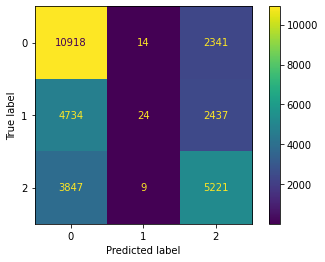

In [233]:
y_pred = model_noFT.predict([train_home, train_away, X]).argmax(axis=-1)
cm_metrics(y,y_pred, [0,1,2])


accuracy:  0.5312034655475836
Recall: 
 {0: 0.8035552877372703, 1: 0.0011117287381878821, 2: 0.5531070956368445} 
Precision: 
 {0: 0.5512608515915668, 1: 0.16666666666666666, 2: 0.4946787544343713} 
F1-score: 
 {0: 0.6539168812063259, 1: 0.0022087244616234127, 2: 0.5222638368705785}


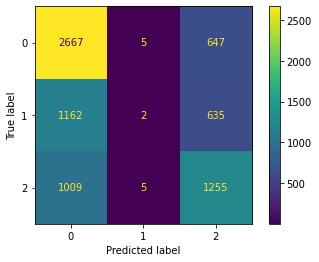

In [234]:
y_test_pred = model_noFT.predict([XH_test,XA_test,Xplayers_test]).argmax(axis=-1)
cm_metrics(y_test,y_test_pred, [0,1,2])

# Essais avec fine tuning

## 1
<b>full trainable mais on garde que la sortie des LSTM (concat: LSTM_model.layers[-7])</b>
sinon archi du 7e essai:  

home_input = tf.keras.Input(shape = (10,6), name = 'home_train_input')  
away_input = tf.keras.Input(shape = (10,6), name = 'away_train_input')  
LSTM_output = base_LSTM_model([home_input,away_input])  
LSTM_output = tf.keras.layers.BatchNormalization()(LSTM_output)


player_input = tf.keras.Input(shape = (198), name = 'player_train_input')  
concat_layer = tf.keras.layers.Concatenate(name='concat_layer')([LSTM_output,player_input])  
Dense1 = tf.keras.layers.Dense(256,'relu',name = 'Dense1')(concat_layer)  
Dense1 = tf.keras.layers.Dropout(0.234375)(Dense1)  
Dense2 = tf.keras.layers.Dense(128,'relu',name='Dense2')(Dense1)  
Dense2 = tf.keras.layers.Dropout(0.125)(Dense2)  
Dense_output = tf.keras.layers.Dense(3, 'softmax', name='output')(Dense2)   

    Overfitting de dingue. on arrive rapidement à une train_acc = 80% pour une val_acc = 45% (baseline)
    trop de Dense layers? essayons avec moins

## 2 
<b>full trainable mais on garde que la sortie des LSTM après dropout (LSTM_model.layers[-6])  
On retire des layers Dense dans l'architecture pour éviter l'overfitting</b>

    Meme problème, aucune différence